In [78]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

## Loading the spatial tessellation
Taking the shapefile of the 155 [urban areas](https://it.wikipedia.org/wiki/Zone_urbanistiche_di_Roma).

In [59]:
URL_TO_DATA = 'https://drive.google.com/open?id=0B61k9xip8kT3Qk1MbzBGQUNaT1E'.replace('/open?', '/uc?')

gdf_rome = gpd.read_file(URL_TO_DATA)
print(gdf_rome.shape)
print(gdf_rome.crs)
gdf_rome.head()

(155, 8)
epsg:32633


,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON Z ((294658.952 4639994.348 0.000, 2946..."
1,Tuscolano Sud,Tuscolano Sud,9B,1.0,7.0,1.0,316.0,"POLYGON Z ((294988.147 4637592.340 0.000, 2949..."
2,Tor Fiscale,Tor Fiscale,9C,1.0,7.0,1.0,91.0,"POLYGON Z ((295420.892 4637038.028 0.000, 2954..."
3,Appio,Appio,9D,1.0,7.0,1.0,134.0,"POLYGON Z ((293294.576 4638903.640 0.000, 2932..."
4,Latino,Latino,9E,1.0,7.0,1.0,159.0,"POLYGON Z ((292789.674 4637982.143 0.000, 2927..."


In [11]:
# CODZU is a unique ID of each urban area
len(gdf_rome.CODZU)

# note: the total area ('SUPERFICIE') is in hectares (1 hectare = 0.01 km^2)

155

## Covariates

### Point-features
These are features like:
- traffic lights
- POIs

from which we will compute a measure of density for each of the urban areas.

#### Traffic lights

In [50]:
URL_TO_DATA = 'https://www.comune.roma.it/TERRITORIO/geoserver/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=dit:Semafori&SRSNAME=EPSG:6708&outputFormat=SHAPE-ZIP'

gdf_tl = gpd.read_file(URL_TO_DATA)
print(gdf_tl.shape)
print(gdf_tl.crs)
gdf_tl.head()

(1541, 9)
epsg:6708


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (294246.969 4642743.354)
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (293526.621 4642757.220)
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (295076.397 4642760.961)
3,17058,APL,Via Cipro,None,P.le degli Eroi,Ospedale Oftalmico,I,None,POINT (288360.167 4642762.393)
4,17025,V,Viale Giulio Cesare,None,Via Candia,Via Leone IV,I,Sigma Plus,POINT (288962.732 4642769.784)


In [51]:
# reprojecting onto epsg:32633
gdf_tl_proj = gdf_tl.to_crs(gdf_rome.crs)

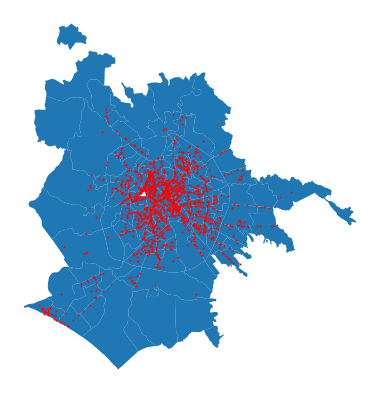

In [52]:
ax = gdf_rome.plot(figsize=(7,7))
gdf_tl_proj.plot(ax=ax, color='red', markersize=0.8)
ax.set_axis_off()

In [54]:
gdf_tl_join = gpd.sjoin(gdf_tl_proj, gdf_rome, how="inner", op='intersects')
print(gdf_tl_join.shape)
gdf_tl_join.head()

(1544, 17)


,COD_IMP,TIPO,VIA_1,CIV,VIA_2,VIA_3,CIRC,SISTEMA_1,geometry,index_right,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE
0,03036,V,Via Catania,None,Via Pavia,Via Cremona,II,Tmacs,POINT (294246.969 4642743.354),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
1,03017,V,Viale Regina Margherita,None,Via Giovanni Battista Morgagni,None,II,Tmacs,POINT (293526.621 4642757.220),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
2,03069,CL,Via della Stazione Tiburtina,None,Via G. Mazzoni,None,II,None,POINT (295076.397 4642760.961),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
74,03004,V,Via Nomentana,None,Viale Pola,Via Bosio,II,Omnia,POINT (293761.139 4643576.052),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0
82,03064,CL,Circonvallazione Nomentana,328,Via Salento,Tang. Est direzione Foro Italico,II,None,POINT (294914.017 4643637.399),108,Nomentano,Nomentano,3A,1.0,2.0,1.0,291.0


In [60]:
tl_number = gdf_tl_join['CODZU'].value_counts().reset_index()
tl_number.columns = ['CODZU', 'n_traffic_lights']

gdf_rome = gdf_rome.merge(tl_number, how='left', on='CODZU')
print(gdf_rome.shape)
gdf_rome.head()

(155, 9)


,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry,n_traffic_lights
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON Z ((294658.952 4639994.348 0.000, 2946...",28.0
1,Tuscolano Sud,Tuscolano Sud,9B,1.0,7.0,1.0,316.0,"POLYGON Z ((294988.147 4637592.340 0.000, 2949...",25.0
2,Tor Fiscale,Tor Fiscale,9C,1.0,7.0,1.0,91.0,"POLYGON Z ((295420.892 4637038.028 0.000, 2954...",3.0
3,Appio,Appio,9D,1.0,7.0,1.0,134.0,"POLYGON Z ((293294.576 4638903.640 0.000, 2932...",13.0
4,Latino,Latino,9E,1.0,7.0,1.0,159.0,"POLYGON Z ((292789.674 4637982.143 0.000, 2927...",5.0


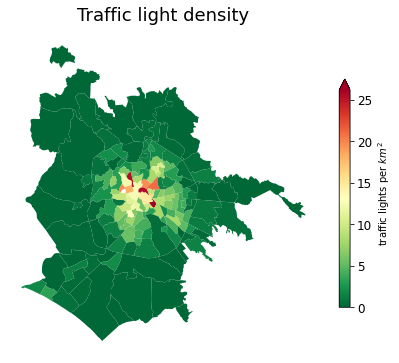

In [98]:
# NaNs are areas where there are zero traffic lights
gdf_rome['n_traffic_lights'] = gdf_rome['n_traffic_lights'].fillna(0)

# compute traffic light density for each area:
gdf_rome['density_traffic_lights'] = gdf_rome['n_traffic_lights'] / (gdf_rome['SUPERFICIE']*0.01)

fig, ax = plt.subplots(1, figsize=(7,7))
gdf_rome.plot(ax=ax, column='density_traffic_lights', cmap='RdYlGn_r', 
              legend=True, legend_kwds={'label': r"traffic lights per $km^2$", 
                                        'orientation': "vertical", 
                                        'shrink':0.6, 'extend':'max'})
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=12)

ax.set_title('Traffic light density', fontsize=18, pad=10)
ax.set_axis_off()

### Network features
There features are like
- network density
- edges’ betweenness centrality
- ratio of motorway roads

that can be computed from OpenStreetMap's data.

### Mapparoma's features
These features are the ones we get directly from the [#mapparoma project's open data](https://www.mapparoma.info/open-data/), like
- public transport accessibility
- nmber of car accidents
- population density